In [1]:
#from qutip import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy.special import genlaguerre as L
from scipy.integrate import solve_ivp as solve
from scipy.integrate import odeint
import time

In [2]:
hbar = sp.constants.hbar
h = sp.constants.h
c = sp.constants.c
e = sp.constants.e
eVtoJ = 1.602176634e-19
amutokg = 1.66053906660e-27

omega = 2.0*np.pi*778e3 #Lange
Omegarf = 2.0*np.pi*13e6 #Lange
m = 170.936331517*amutokg
beta = 0.0
alpha = 5.89e-40 #J m^2 V^-2 E2 transition (Lange)
nu0 = 688358979309307.82 #Hz E2 transition (Huntemann)

In [3]:
def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n    #returns prob of being in state n given nbar

def dopAndStark(n):       #for 1D!! to make 3d, multiply this by 3                        
    return 0.0#-2.0*np.pi*nu0*hbar*omega*(n+0.5)/(m*c**2)*(1.0 + alpha*m**2*Omegarf**2*c**2/(h*nu0*e**2*2)) 

def Omega(n,m,eta):
    return np.abs(np.exp(-eta**2/2.0) * eta**(np.abs(m)) * (math.factorial(n)/math.factorial(n+m))**(np.sign(m)/2.0) \
        * L(n,np.abs(m))(eta**2))             #returns unitless rabi rate of transition n -> n+m given Lamb-Dicke Parameter

def fastOmega(n,m,eta):
    return 1.0 - eta**2.0*n

eta = 0.1
omegas = np.zeros(500)
for ii in range(np.size(omegas)):
    omegas[ii] = Omega(ii,0,eta)

D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:651: RuntimeWarning: invalid value encountered in double_scalars
  hn = _gam(n + alpha + 1) / _gam(n + 1)
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:140: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:196: RuntimeWarning: overflow encountered in true_divide
  w = 1.0 / (fm * dy)
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:202: RuntimeWarning: invalid value encountered in multiply
  w *= mu0 / w.sum()
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:127: RuntimeWarning: invalid value encountered in double_scalars
  equiv_weights = [weights[k] / wfunc(roots[k]) for
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:196: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / (fm * dy)
D:\Mark\Python\lib\site-packages\scipy\special\_or

In [8]:
prob(3,2)

0.0987654320987654

In [6]:
#takes rho as a 3 element vector and converts it to a 2x2 matrix by calculating the conj. of rhoge
def subpulse(rho0, t, Omega0, delta):
    rho = np.array([[rho0[0], rho0[2]],[np.conj(rho0[2]), rho0[1]]])
    Omega = np.sqrt(Omega0**2 + delta**2)
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    rho = U@rho@np.conj(U)
    return np.array([rho[0,0], rho[1,1], rho[0,1]])

def pulse(rho0, t, Omega0, delta):
    Ncut = rho0.size//3 - 1
    rho = np.array([0.0+0.0j]*3*(Ncut+1))
    for n in range(Ncut):
        rho[3*n:3*(n+1)] = subpulse(rho0[3*n:3*(n+1)], t, Omega0*omegas[n], delta)
    return rho

In [7]:
def heatEqns(t, rho, nbardot):
    Ncut = rho.shape[0]//3 - 1
    rhoDot = [0.0+0.0j]*((Ncut+1)*3)
    for ii in range(3):
        rhoDot[0+ii] = nbardot*(-rho[0+ii]+rho[3*1+ii])
        rhoDot[3*Ncut+ii] = nbardot*(-Ncut*rho[3*Ncut+ii]+Ncut*rho[3*(Ncut-1)+ii])
        #Note*** the above line is true in the limit that rho[Ncut+1,ii]=rho[Ncut,ii] (fair assumption for large Ncut I think)
        for n in range(1,Ncut-1):
            rhoDot[3*n+ii] = nbardot*(-(2.0*n+1.0)*rho[3*n+ii] + (n+1.0)*rho[3*(n+1)+ii] + n*rho[3*(n-1)+ii])
    return rhoDot

def heat(rho0, t, nbardot):
    rho = solve(heatEqns, [0.0,t], rho0, args=[nbardot]).y[:,-1]
    return rho

def fastHeat(rho0, t, nbardot, Nstop):
    #Nstop = 100
    Ncut = rho0.shape[0]//3 - 1
    rho = np.array([0.0+0.0j]*3*(Ncut+1))
    rho[:3*Nstop] = solve(heatEqns, [0.0,t], rho0[:3*Nstop], args=[nbardot]).y[:,-1]
    rho[3*Nstop:] = rho0[3*Nstop:]
    return rho

In [8]:
def subFreeEvo(rho0, phi):
    return np.array([rho0[0], rho0[1], rho0[2]*np.exp(-1.0j*phi)])

def freeEvo(rho0, phi):
    Ncut = rho0.size//3 - 1
    rho = np.array([0.0+0.0j]*3*(Ncut+1))
    for n in range(Ncut):
        rho[3*n:3*(n+1)] = subFreeEvo(rho0[3*n:3*(n+1)], phi)
    return rho

In [9]:
def groundRho(Ncut, nbar):
    rho = np.array([0.0+0.0j]*3*(Ncut+1))
    for n in range(Ncut):
        rho[3*n] = prob(n,nbar)
    return rho

def nbar(rho):
    Ncut = rho.shape[0]//3
    nbar = 0.0
    for n in range(Ncut):
        nbar += n*(rho[n*3].real + rho[n*3+1].real)
    return nbar

def rhogg(rho):
    rhogg = 0.0
    Ncut = rho.shape[0]//3
    for n in range(Ncut):
        rhogg += rho[(3*n)].real
    return rhogg

def rhoee(rho):
    rhoee = 0.0
    Ncut = rho.shape[0]//3
    for n in range(Ncut):
        rhoee += rho[(3*n)+1].real
    return rhoee

In [10]:
def ramsey(rho0, t1, T, t2, deld, delPrime, Omega0):
    intState = freeEvo(pulse(rho0, t1, Omega0, delPrime), deld*T)
    result = pulse(intState, t2, Omega0, delPrime)
    return result

def heatRamsey(rho0, t1, T, t2, deld, Delta, Omega0, nbardot):
    delPrime = deld - Delta
    Nstop1 = 100
    ni = nbar(rho0)
    nDarkTimeAvg = ni+nbardot*(2.0*t1+T)/2.0 #avg nbar during the dark time, gives us the phase accum
    intState = freeEvo(fastHeat(pulse(rho0, t1, Omega0, delPrime+dopAndStark(ni)), t1, nbardot, Nstop1), (deld+dopAndStark(nDarkTimeAvg))*T)
    Nstop2 = 350
    instState = fastHeat(intState, T, nbardot, Nstop2)
    n = nbardot*(t1+T)
    result = pulse(intState, t2, Omega0, delPrime+dopAndStark(n))
    return result

def RamseyErrSig(deld, rho0, t1, T, t2, delPrime, Omega0):
    intState = freeEvo(pulse(rho0, t1, Omega0, delPrime), deld*T)
    resultP = pulse(freeEvo(intState, np.pi/2.0), t2, Omega0, delPrime)
    resultM = pulse(freeEvo(intState, -np.pi/2.0), t2, Omega0, delPrime)                   
    return rhoee(resultP) - rhoee(resultM)

def HRSJumpErrSig(deld, rho0, t1, T, t2, delPrime, Omega0):
    intState = freeEvo(pulse(rho0, t1, Omega0, delPrime), deld*T)
    resultP = pulse(pulse(freeEvo(intState,np.pi/2.0),2.0*t2/3.0,-Omega0,delPrime),t2/3.0,Omega0,delPrime)
    resultM = pulse(pulse(freeEvo(intState,-np.pi/2.0),2.0*t2/3.0,-Omega0,delPrime),t2/3.0,Omega0,delPrime)
    return rhoee(resultP) - rhoee(resultM)

def heatRSErrSigLSEE(deld, rho0, t1, T, t2, Delta, Omega0, nbardot):
    delPrime = deld - Delta
    #Nstop1 = 100
    ni = nbar(rho0)
    nDarkTimeAvg = ni+nbardot*(2.0*t1+T)/2.0 #avg nbar during the dark time, gives us the phase accum
    intState = freeEvo(heat(pulse(rho0, t1, Omega0, delPrime+dopAndStark(ni)), t1, nbardot), (deld+dopAndStark(nDarkTimeAvg))*T)
    #Nstop2 = 350
    instState = heat(intState, T, nbardot)
    n = nbardot*(t1+T)
    resultP = pulse(pulse(freeEvo(intState, np.pi/2.0), 2.*t2/3., -Omega0, delPrime+dopAndStark(n)), t2/3., Omega0, delPrime+dopAndStark(n))
    resultM = pulse(pulse(freeEvo(intState, -np.pi/2.0), 2.*t2/3., -Omega0, delPrime+dopAndStark(n)), t2/3., Omega0, delPrime+dopAndStark(n))
    return rhoee(resultP) - rhoee(resultM)

def heatHRSErrSigLSEE(deld, rho0, t1, T, t2, Delta, Omega0, nbardot):
    delPrime = deld - Delta
    intState = heat(pulse(rho0, t1/3., Omega0, delPrime), t1/3., nbardot)
    intState = heat(freeEvo(heat(pulse(intState, 2.*t1/3.0, -Omega0, delPrime), 2.*t2/3., nbardot), deld*T), T, nbardot)
    resultP = pulse(freeEvo(intState,np.pi/2.), t2, Omega0, delPrime)
    resultM = pulse(freeEvo(intState,-np.pi/2.), t2, Omega0, delPrime)
    return rhoee(resultP) - rhoee(resultM)

In [65]:
Omega0 = 10.0*2.0*np.pi
nbardot = 3.0*Omega0/(2.0*np.pi)
t1 = np.pi/(2.0*Omega0)
T = 4.0*t1
t2 = 3.0*t1
Ncut = 270
nbar0 = 20.0
rho0 = groundRho(Ncut, nbar0)

pts = 5
Deltas = np.linspace(0.0, 0.01*Omega0, pts)
shifts = np.zeros(pts)
#Delta = 0.1/(2.0*np.pi)

tol = 1.0e-6
x0 = -0.1
x1 = 0.1
guessTol = 0.1

for ii in range(pts):
    print("Delta = ", Deltas[ii])
    start = time.time()
    shifts[ii] = sp.optimize.root_scalar(heatRSErrSigLSEE, args=(rho0, t1, T, t2, Deltas[ii], Omega0, nbardot), bracket=[x0,x1], xtol = tol).root
    end = time.time()
    print("time = ", end-start)
    print("shift = ", shifts[ii])
    x0 = shifts[ii] - guessTol
    x1 = shifts[ii] + guessTol
    print("bracket = ", x0,x1)

Delta =  0.0
time =  31.065525770187378
shift =  0.0
bracket =  -0.1 0.1
Delta =  0.15707963267948966
time =  51.424996852874756
shift =  4.3329539106776464e-05
bracket =  -0.09995667046089322 0.10004332953910679
Delta =  0.3141592653589793
time =  51.91006326675415
shift =  9.207834979265931e-05
bracket =  -0.09990792165020734 0.10009207834979267
Delta =  0.47123889803846897
time =  52.30112552642822
shift =  0.00015166175506483985
bracket =  -0.09984833824493516 0.10015166175506485
Delta =  0.6283185307179586
time =  53.8185179233551
shift =  0.00022748718919999043
bracket =  -0.09977251281080002 0.10022748718919999


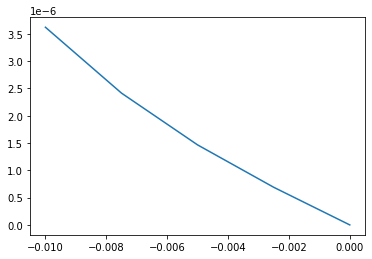

In [67]:
plt.plot(-Deltas/Omega0, shifts/Omega0)

In [11]:
Omega0 = 10.0*2.0*np.pi
nbardot = 3.0*Omega0/(2.0*np.pi)
t1 = 3.0*np.pi/(2.0*Omega0)
T = 4.0*t1/3.0
t2 = t1/3.0
Ncut = 270
nbar0 = 20.0
rho0 = groundRho(Ncut, nbar0)

pts = 5
Deltas = np.linspace(0.0, 0.01*Omega0, pts)
shifts = np.zeros(pts)
#Delta = 0.1/(2.0*np.pi)

tol = 1.0e-6
x0 = -0.1
x1 = 0.1
guessTol = 0.1

for ii in range(pts):
    print("Delta = ", Deltas[ii])
    start = time.time()
    shifts[ii] = sp.optimize.root_scalar(heatHRSErrSigLSEE, args=(rho0, t1, T, t2, Deltas[ii], Omega0, nbardot), bracket=[x0,x1], xtol = tol).root
    end = time.time()
    print("time = ", end-start)
    print("shift = ", shifts[ii])
    x0 = shifts[ii] - guessTol
    x1 = shifts[ii] + guessTol
    print("bracket = ", x0,x1)

Delta =  0.0
time =  35.42776346206665
shift =  0.0
bracket =  -0.1 0.1
Delta =  0.15707963267948966
time =  57.15853977203369
shift =  -0.0009897662539953775
bracket =  -0.10098976625399539 0.09901023374600462
Delta =  0.3141592653589793
time =  58.816526889801025
shift =  -0.001973832885925891
bracket =  -0.1019738328859259 0.09802616711407411
Delta =  0.47123889803846897
time =  58.41828513145447
shift =  -0.0029465046759127914
bracket =  -0.10294650467591279 0.09705349532408722
Delta =  0.6283185307179586
time =  58.24189901351929
shift =  -0.0039020950476803804
bracket =  -0.10390209504768039 0.09609790495231962


In [20]:
nbar(heatRamsey(rho0, t1, T, t2, 8.055196534194968e-10, Delta, Omega0, nbardot))

22.688448218251594

In [16]:
groundRho(270, 40).shape[0]//3

271

In [27]:
-0.02611884469525285/(2.0*np.pi)

-0.00415694324109902

In [38]:
 0.004727923751627341/Omega0

7.524724356330698e-05

In [45]:
0.1*Omega0

6.283185307179586

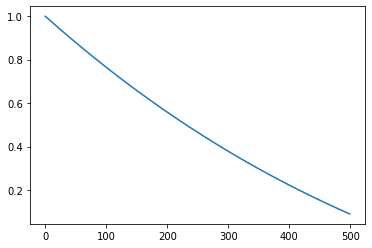

In [9]:
plt.plot(omegas)

In [7]:
np.size(omegas)

500

In [20]:
ns = np.linspace(0,1000,1001)
tot = 0.
probs = np.zeros(1001)
for ii in range(1001):
    probs[ii] = prob(ii,10.)
    tot += probs[ii]

In [21]:
tot-1

-6.661338147750939e-16

In [45]:
ns = np.arange(0,270,10)
nbar = 58.
tot2 = 0.
probs2 = np.zeros(np.size(ns))
for ii in range(np.size(ns)):
    probs2[ii] = prob(ns[ii],nbar)
    tot2 += probs2[ii]

In [46]:
10.*tot2

1.0679845495498126

In [37]:
ns = np.arange(0,270,10)
ns

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
       260])

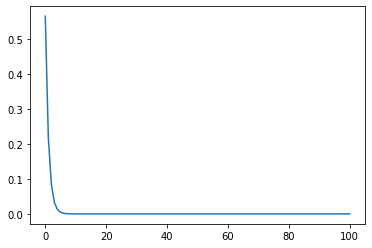

In [31]:
plt.plot(probs2)